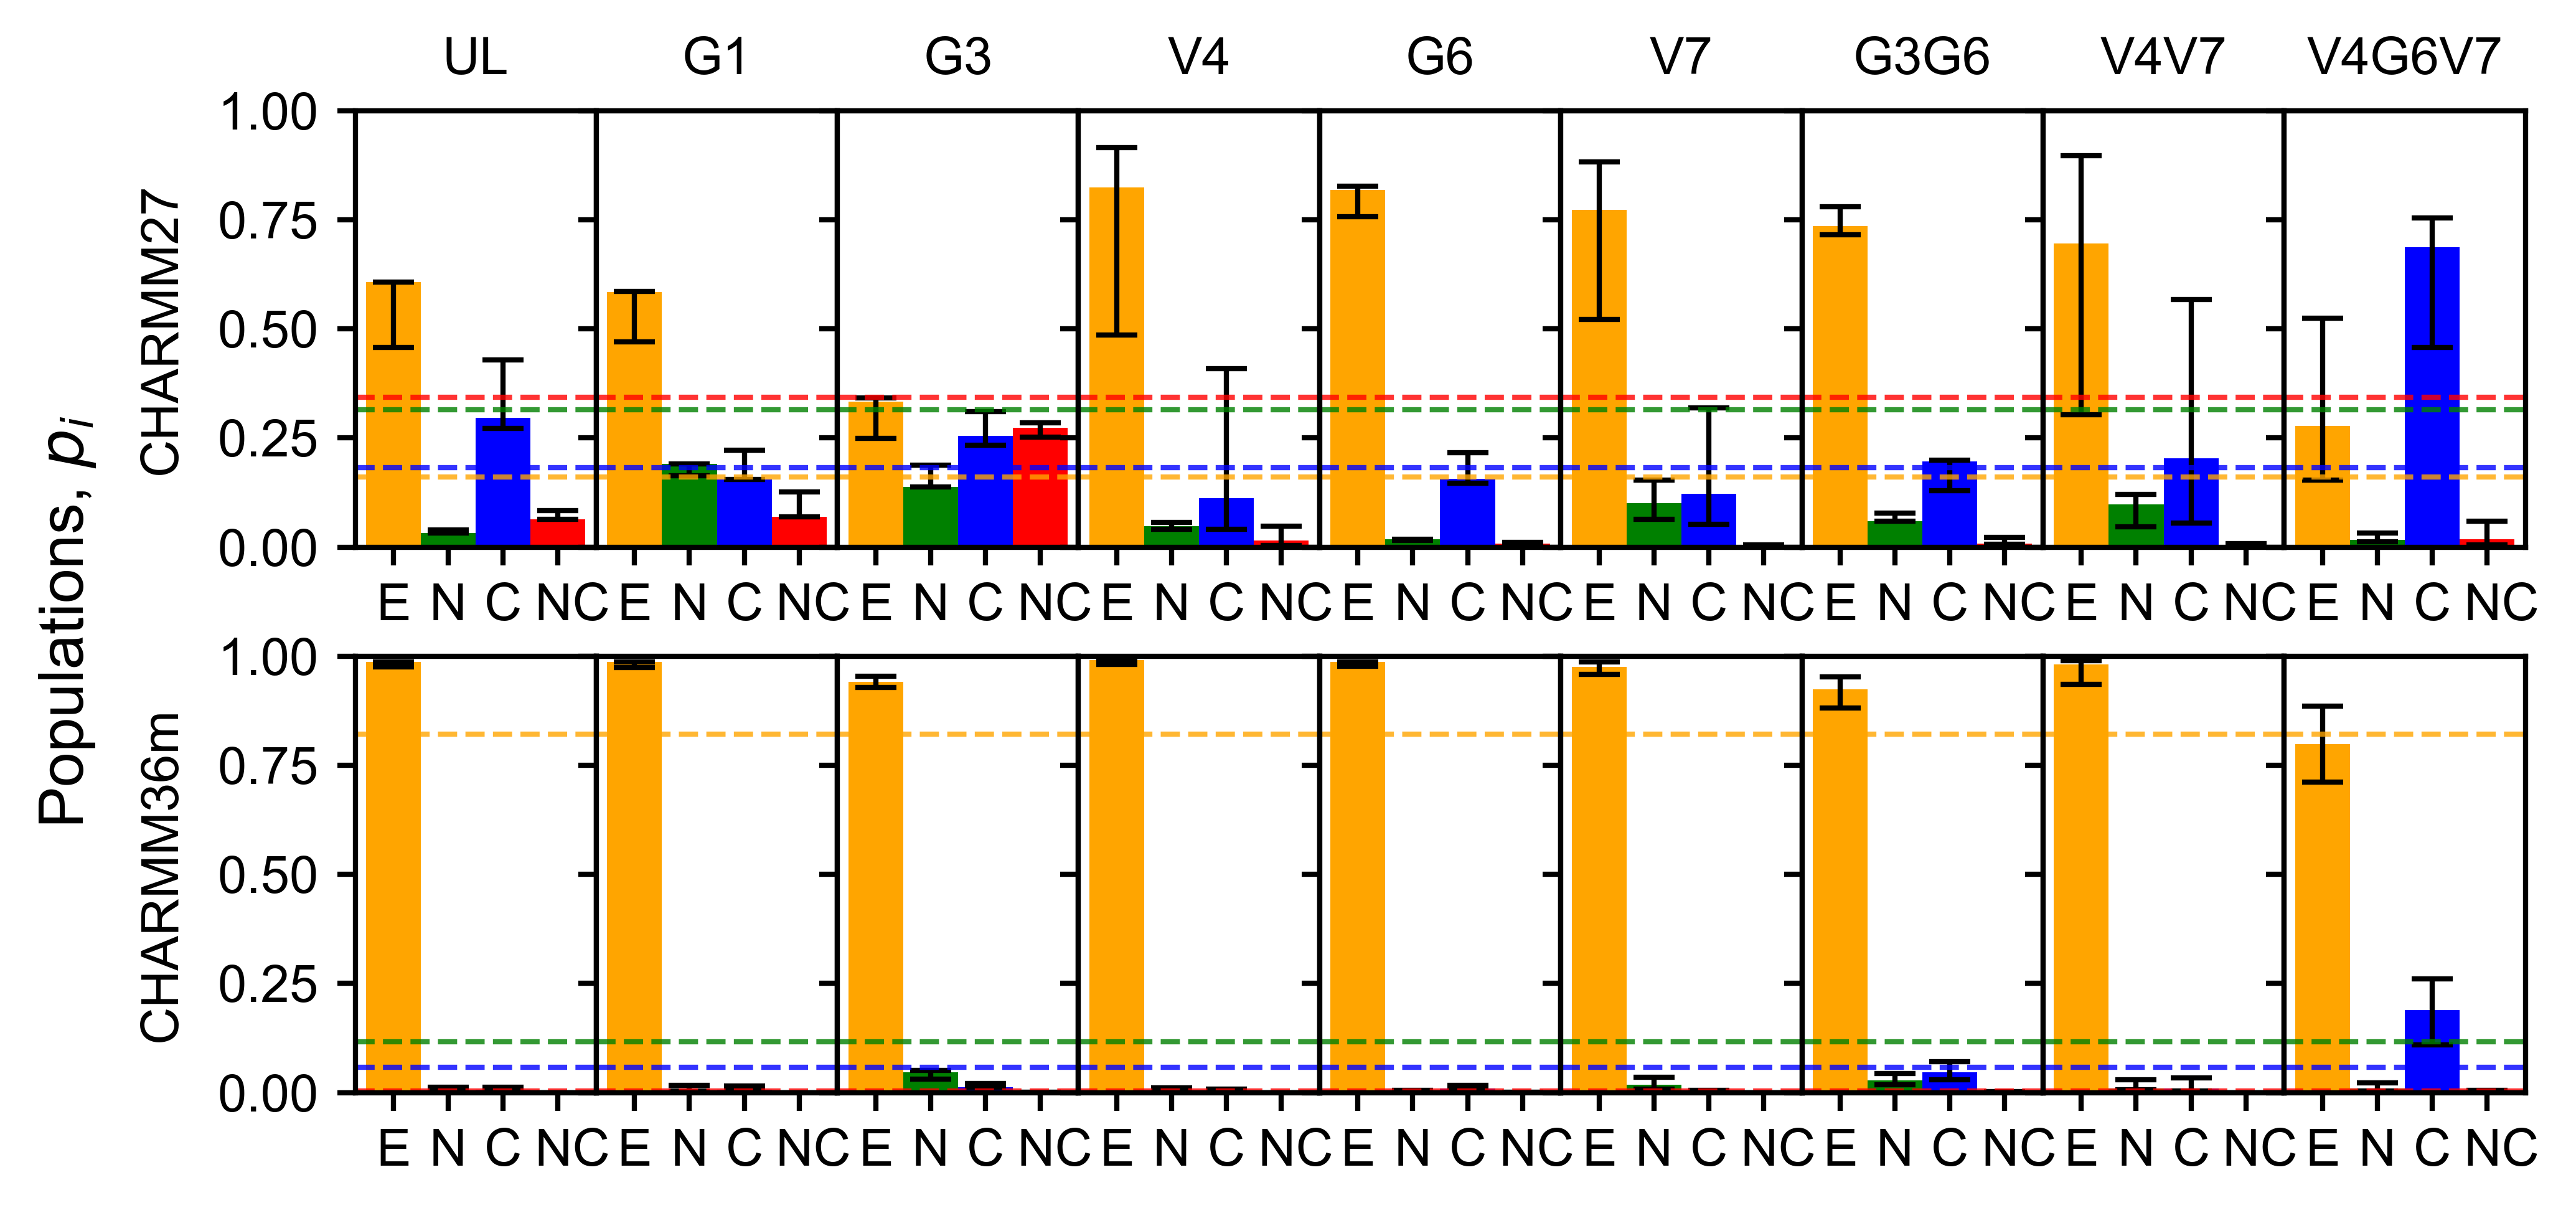

In [1]:
### PLOTS INDIVIDUAL REFINEMENT (FIG 6) IN MAIN TEXT ###
### 1 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
#BASE_DIR = Path('/project/dinner/ianjefab/papers/202508_ELP/data')
BASE_DIR = Path('../data')
ERROR_DIR = BASE_DIR / 'error_data' / 'overlap_full'
PROP_DIR = BASE_DIR / 'prop_array'

# Data Specifications
FORCE_FIELDS = ['CHARMM27_TIP3P', 'CHARMM36m_TIP3P']  # 2 force fields
FORCE_FIELD_LABELS = ['CHARMM27', 'CHARMM36m']  # Plot labels
ISOTOPES = ['WT', 'G3+', 'G5+', 'V1', 'G3', 'V4', 'G5+G3', 'V1V4', 'V1G3V4']  # 9 isotopologues
ISOTOPE_LABELS = {  # Maps system names to publication labels
    'WT': 'UL', 'G3+': 'G1', 'G5+': 'G3', 'V1': 'V4', 'G3': 'G6', 'V4': 'V7',
    'G5+G3': 'G3G6', 'V1V4': 'V4V7', 'V1G3V4': 'V4G6V7'
}

# State definitions
STATE_KEYS = ['C', 'E', 'NC', 'N']
STATE_PLOT_ORDER = ['E', 'N', 'C', 'NC']
STATE_PLOT_LABELS = ['E', 'N', 'C', '  NC']  # Extra space for NC alignment
STATE_COLORS = ['orange', 'green', 'blue', 'red']

# Analysis Parameters
SHIFT_VALUES = [-2, 0, 2]
ESS_TARGET = 100
THETA_RANGE = np.logspace(-1, 4, 1000)  # Shape: (1000,) - Reweighting parameters 0.1 to 10000

# Plotting Specifications
FIGURE_SIZE = (7, 3.6)
DPI = 600

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

def load_error_data_single_isotope(force_field, isotope, shift):
    """Load error data for single isotope (NOT summed across isotopes).
    
    Args:
        force_field: Force field name
        isotope: Single isotope name
        shift: Wavenumber shift value
        
    Returns:
        np.array: Error matrix for this isotope only, shape (5000, 1000)
    """
    filename = f'error_overlap_{isotope}_{force_field}_ch27_{shift}.npy'
    filepath = ERROR_DIR / filename
    if not filepath.exists():
        raise FileNotFoundError(f"Missing error file: {filepath}")
    return np.load(filepath)  # Shape: (5000, 1000) - single isotope errors

def load_proportions(force_field):
    """Load state proportions for given force field.
    
    Returns:
        np.array: Proportions array, shape (5000, 4)
    """
    filepath = PROP_DIR / force_field / f'proportions_array_0100ps_{force_field}_PAPER.npy'
    return np.load(filepath)  # Shape: (5000, 4)
    # Each row: [proportion_C, proportion_E, proportion_NC, proportion_N]
    # Values between 0-1, each row sums to 1.0

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def compute_ess(weights):
    """Compute effective sample size from weights.
    
    Args:
        weights: Reweighting weights, shape (5000, 1000)
        
    Returns:
        np.array: ESS values, shape (1000,) - one per theta
    """
    sum_weights = np.sum(weights, axis=0)  # Shape: (1000,)
    sum_weights_squared = np.sum(weights**2, axis=0)  # Shape: (1000,)
    return np.divide(sum_weights**2, sum_weights_squared, 
                    out=np.full_like(sum_weights, np.nan), 
                    where=sum_weights_squared != 0)  # Shape: (1000,)

def compute_reweighted_populations(error, proportions):
    """Calculate reweighted populations and ESS across theta range.
    Same procedure as Figure 5, but applied to single isotope error data.
    
    Args:
        error: Error matrix for single isotope, shape (5000, 1000)
        proportions: State proportions, shape (5000, 4)
        
    Returns:
        tuple: (reweighted_populations dict, ess array)
    """
    weights = np.exp(-error)  # Shape: (5000, 1000)
    weights /= np.sum(weights, axis=0, keepdims=True)  # Normalize, each column sums to 1
    
    # Same reweighting calculation as Figure 5, but for single isotope
    reweighted = {
        state: np.sum(proportions[:, idx:idx+1] * weights, axis=0)
        for idx, state in enumerate(STATE_KEYS)
    }  # Each state: shape (1000,)
    
    ess = compute_ess(weights)  # Shape: (1000,)
    return reweighted, ess

def find_best_theta_index(ess_array):
    """Find index for target ESS of 100.
    
    Args:
        ess_array: ESS values, shape (1000,)
        
    Returns:
        int: Best theta index (0-999)
    """
    valid_ess = np.nan_to_num(ess_array, nan=-np.inf)
    return np.argmin(np.abs(valid_ess - ESS_TARGET))  # Closest to target

def extract_plot_data(shift_results):
    """Extract final values and error bars for single isotope plot.
    EXACTLY the same error bar calculation as Figure 5, but for individual isotope.
    
    Args:
        shift_results: Results dict for all shifts
        
    Returns:
        tuple: (reference_values, error_bars) both shape (4,) and (2,4)
    """
    if 0 not in shift_results:
        raise ValueError("Missing reference data for shift=0.")
    
    # Get reference values from shift=0
    reference_idx = shift_results[0]['best_idx']
    reference_values = [shift_results[0]['populations'][state][reference_idx] 
                       for state in STATE_PLOT_ORDER]  # Shape: (4,)
    
    # Collect values across all shifts
    all_values_matrix = []
    for shift in sorted(shift_results.keys()):  # [-2, 0, 2]
        idx = shift_results[shift]['best_idx']
        values = [shift_results[shift]['populations'][state][idx] 
                 for state in STATE_PLOT_ORDER]
        all_values_matrix.append(values)
    
    all_values_matrix = np.array(all_values_matrix)  # Shape: (3, 4)
    min_values = np.min(all_values_matrix, axis=0)  # Shape: (4,)
    max_values = np.max(all_values_matrix, axis=0)  # Shape: (4,)
    
    # Calculate error bars relative to reference
    error_bars = np.array([
        np.array(reference_values) - min_values,  # Lower error bars
        max_values - np.array(reference_values)   # Upper error bars
    ])  # Shape: (2, 4)
    
    return reference_values, error_bars

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })

def add_reference_lines(ax, original_average):
    """Add horizontal dashed lines for original populations.
    
    Args:
        ax: Matplotlib axis
        original_average: Original average proportions, shape (4,)
    """
    for idx, state in enumerate(STATE_PLOT_ORDER):
        state_idx = STATE_KEYS.index(state)
        ax.axhline(y=original_average[state_idx], 
                  color=STATE_COLORS[idx], 
                  linestyle="--", 
                  linewidth=1.0, 
                  alpha=0.8)

def plot_isotope_populations(ax, values, errors, original_average):
    """Plot populations for single isotope with error bars.
    
    Args:
        ax: Matplotlib axis
        values: Population values, shape (4,)
        errors: Error bars, shape (2, 4)
        original_average: Original averages, shape (4,)
    """
    ax.bar(STATE_PLOT_LABELS, values, yerr=errors, capsize=4, 
           color=STATE_COLORS, width=1.0,
           error_kw={'linewidth': 1.0, 'capthick': 1.0})
    add_reference_lines(ax, original_average)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='both', labelsize=10)

def create_figure(results):
    """Create complete 2×9 grid figure with all isotope subplots.
    
    Args:
        results: Dictionary with (force_field, isotope) keys containing plot data
    """
    fig, axes = plt.subplots(2, 9, figsize=FIGURE_SIZE, sharey=True, dpi=DPI)
    fig.subplots_adjust(left=0.15, right=0.98, top=0.88, bottom=0.15, 
                       wspace=0, hspace=0.25)
    
    # Add isotope labels at top
    for col, isotope in enumerate(ISOTOPES):
        pos = plt.subplot(2, 9, col + 1).get_position()
        fig.text(pos.x0 + pos.width / 2, 0.90, ISOTOPE_LABELS[isotope], 
                ha='center', va='bottom', fontsize=10)
    
    # Plot data for each force field × isotope combination
    for row, force_field in enumerate(FORCE_FIELDS):
        for col, isotope in enumerate(ISOTOPES):
            ax = axes[row, col]
            
            if (force_field, isotope) not in results:
                ax.axis('off')  # Hide subplot if no data
                continue
            
            values = results[(force_field, isotope)]['values']
            errors = results[(force_field, isotope)]['errors']
            original_average = results[(force_field, isotope)]['original_average']
            
            plot_isotope_populations(ax, values, errors, original_average)
            
            if col != 0:
                ax.yaxis.set_tick_params(labelleft=False)  # Hide y-labels except leftmost
    
    # Add force field labels on left
    for row, label in enumerate(FORCE_FIELD_LABELS):
        axes[row, 0].text(-0.7, 0.5, label, transform=axes[row, 0].transAxes,
                         fontsize=10, ha='right', va='center', rotation=90)
    
    # Add y-axis label
    fig.text(0.04, 0.5, 'Populations, $p_i$', ha='center', va='center', 
             fontsize=12, rotation=90, transform=fig.transFigure)
    
    plt.show()

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function to generate Figure 6.
    For each combination of force field and isotope:
    1. Load error data for SINGLE isotope (not summed)
    2. Apply EXACTLY the same reweighting procedure as Figure 5
    3. Calculate populations and error bars across shifts (same method)
    4. Create 2×9 grid plot showing all isotopes individually
    
    This shows how each isotope contributes to the combined analysis in Figure 5.
    """
    set_plot_style()
    
    results = {}  # Store results for (force_field, isotope) combinations
    
    # Process all combinations: 2 force fields × 9 isotopes = 18 analyses
    for force_field in FORCE_FIELDS:
        proportions = load_proportions(force_field)  # Shape: (5000, 4)
        original_average = np.mean(proportions, axis=0)  # Shape: (4,)
        
        for isotope in ISOTOPES:
            try:
                shift_results = {}
                
                # EXACTLY the same procedure as Figure 5, but for single isotope
                for shift in SHIFT_VALUES:  # [-2, 0, 2]
                    error = load_error_data_single_isotope(force_field, isotope, shift)  # Shape: (5000, 1000)
                    populations, ess = compute_reweighted_populations(error, proportions)
                    best_idx = find_best_theta_index(ess)
                    shift_results[shift] = {
                        'populations': populations,
                        'ess': ess,
                        'best_idx': best_idx
                    }
                
                # Extract plot data using same method as Figure 5
                values, errors = extract_plot_data(shift_results)  # Shapes: (4,), (2,4)
                results[(force_field, isotope)] = {
                    'values': values,
                    'errors': errors,
                    'original_average': original_average
                }
                
            except FileNotFoundError:
                pass  # Skip missing isotope data
    
    create_figure(results)  # Generate 2×9 grid plot

if __name__ == "__main__":
    main()